In [38]:
import numpy as np
import cv2 as cv
import matplotlib.path as mpltPath
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook

In [39]:
cameraH = np.array([[ 9.42118957e-01,  4.18822851e-01, -7.25736750e+01],
       [-3.63139244e-01,  9.57252119e-01,  1.40435108e+02],
       [ 8.82977443e-05,  1.30033207e-04,  1.00000000e+00]])

translation_vector = np.array([ 61.09920255, -16.,   0.])

In [40]:
#note: different resolutions have different coordinate systems...

#timestamp location for 1280x960
mask_points_time1 = np.array([[587.5, 19.8],
                             [587.5, 32.2],
                             [689.8, 32.2],
                             [689.8, 19.8]])

#timestamp location for 640x480
mask_points_time3 = np.array([[267, 32],
                             [267, 20],
                             [372, 20],
                             [372, 32],
                             [272, 32]])

#mask for buildings for camera 1, 1280x960 --> need to divde coordinates by 2 to get the 640x480 coordinates
img1_mask = np.array([[  2.78 , 869.98],
                             [ 3.40, 863.84],
                             [ 5.93, 863.07],
                             [ 6.7, 855.32],
                             [ 7.77,854.01],
                             [ 16.60, 853.17],
                             [ 41.55, 815.55],
                             [ 54.83, 805.65],
                             [ 56.14, 822.31],
                             [ 58.44, 840.66],
                             [ 64.28, 881.04],
                             [ 67.65, 881.81],
                             [ 73.18, 875.2],
                             [ 75.1 , 889.17],
                             [ 79.55 , 890.94],
                             [ 81.01, 894.47],
                             [90.38, 895.24],
                             [ 91.76, 907.29],
                             [96.44, 907.52 ],
                             [102.28, 899.62],
                             [110.18, 881.34],
                             [111.8, 882.8 ],
                             [115.17, 906.45],
                             [167.92, 906.68],
                             [179.92, 907.29],
                             [181.43, 902.61],
                             [185.03, 904.38],
                             [185.11, 910.36],
                             [191.64, 910.44 ],
                             [206.61, 889.41],
                             [214.74, 889.94],
                             [231.8, 908.2],
                             [246.5, 906.2],
                             [317.7, 906.4],
                             [319 , 879.3],
                             [328.9, 879.3],
                             [331.5 , 875.2],
                             [339.2 , 873.9],
                             [342.0, 862.4],
                             [355.6, 882.3],
                             [354.1, 912.3],
                             [376.4, 911.9 ],
                             [379.2, 902],
                             [392.1, 903.7],
                             [392.1, 909.2],
                             [415.2, 910.3],
                             [415.9, 918.7],
                             [469.2, 917.4],
                             [470.5, 912.1],
                             [476.5, 911.6],
                             [482.8, 779],
                             [893.2, 779],
                             [910.0, 938.5],
                             [1022.9, 939.0],
                             [1025.2, 952.8],
                             [1055.4, 952.8],
                             [1052.9, 929.3],
                             [1054.8, 929.3],
                             [1059.3, 956.1],
                             [1093.7, 955.9],
                             [1112.1, 957.8],
                             [1119.1, 941.2],
                             [1119.8, 916.2],
                             [1123.8, 916.8],
                             [1143.7, 956.9],
                             [1156.7, 958.2],
                             [1093.3, 624.8],
                             [1130.8, 551.1],
                             [1125.0, 518.1],
                             [1128.2, 478.4],
                             [1154.5, 526],
                             [1161.8, 551.1],
                             [1202.9, 587.3],
                             [1225.0, 593.7],
                             [1276.8, 801.0]])

#use this for the low res image (640x480) (i think)
img1_mask_lowres = img1_mask/2

#mask for buildings for camera 3 
img3_mask = np.array([[  0.0001 , 431.9],
                             [ 7.78, 397.65],
                             [ 15.16, 399.28],
                             [ 6.05, 445.8],
                             [ 27.63,448.1],
                             [ 28.01, 452.52],
                             [ 33.39, 452.99],
                             [ 34.73, 450.11],
                             [ 69.93, 451.65],
                             [ 71.18, 458.27],
                             [ 75.78, 457.31],
                             [ 76.74, 453.53],
                             [ 83.93, 453.47],
                             [ 84.32 , 457.12],
                             [ 89.11 , 457.6],
                             [ 90.07, 452.71],
                             [97.94, 453.09],
                             [ 98.23, 457.02],
                             [101.49, 456.45 ],
                             [101.49, 451.17],
                             [112.23, 452.62],
                             [114.92, 466.04 ],
                             [124.32, 449.93],
                             [124.70, 459.91],
                             [153.76, 459.52],
                             [154.82, 450.02],
                             [155.39, 451.46],
                             [162.2, 462.97],
                             [174.58, 436.5 ],
                             [176.88, 424.79],
                             [186.18, 424.41],
                             [190.21, 452.52],
                             [192.42, 434.29],
                             [196.25, 434.67],
                             [197.12 ,426.71],
                             [214.86, 427.29],
                             [215.63 , 451.17],
                             [220.23 , 439.28],
                             [226.66, 439.37],
                             [230.88, 460.38],
                             [240.66, 460.19],
                             [243.16, 454.53 ],
                             [251.89, 454.15],
                             [256.87, 446.57],
                             [263.97, 454.43],
                             [264.64, 462.68],
                             [268.1, 462.97],
                             [269.44, 456.45],
                             [278.65, 462.78],
                             [278.84, 459.33],
                             [281.24, 457.85],
                             [296.88, 457.6],
                             [296.1, 462.78],
                             [311.07, 463.55],
                             [313.27, 459.9],
                             [341.67, 460.57],
                             [342.34, 447.82],
                             [346.56, 447.91],
                             [346.37, 462.3],
                             [369.0, 460.76],
                             [368.81, 455.1],
                             [375.62, 455.01],
                             [375.81, 462.30],
                             [395.09, 462.11],
                             [395.0, 449],
                             [399.6, 449.35],
                             [399.5, 460.8],
                             [413.03, 462.3],
                             [412.16, 445.61],
                             [416.0, 444.07],
                             [415.04, 426.91],
                             [425.21, 426.04],
                             [427.13, 432.95],
                             [425.21, 426.04],
                             [427.13, 432.37],
                             [430.96, 426.04],
                             [433.46, 432.37],
                             [439.12,431.99],
                             [438.45, 399.95],
                             [443.05, 400.72],
                             [444.58, 430.93],
                             [555.56, 434.1],
                             [556.62, 437.94],
                             [567.74, 437.07],
                             [580.02, 430.26],
                             [599.88,429.40],
                             [604.19, 437.17],
                             [612.44, 437.46],
                             [613.3, 430.74],
                             [612.46, 432.76],
                             [622.03, 438.42],
                             [628.84, 438.61],
                             [636.04, 470.84],
                             [639.3, 470.55]])


def gen_mask(points, imshape, timemask=None):
    # make blank mask
    ind_y, ind_x = np.meshgrid(np.arange(0.5, imshape[1]),
                               np.arange(0.5, imshape[0]))
    # Ensure the points go to the edge of the image
    newpoints = [[641, points[-1, 1]],
                 [641, -1],
                 [-1, -1],
                 [-1, points[0, 1]],
                 [points[0, 0], points[0, 1]]]
    points = np.concatenate((points, newpoints), axis=0)
    points_poly = mpltPath.Path(points)
    mask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)

    if timemask is not None:
        points_poly = mpltPath.Path(timemask)
        tmask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)
        mask = mask & ~tmask
        
    return mask.transpose()[:, :, None].astype('uint8')

mask_C1 = gen_mask(img1_mask_lowres, (640, 480), timemask=mask_points_time1/2)
mask_C3 = gen_mask(img3_mask, (640, 480), timemask=mask_points_time3)

In [41]:
%cd "C:\Users\kathe\OneDrive - Imperial College London\MSci Project\matrices"
fundamental_matrix = np.loadtxt(r'fundamental_matrix.csv', delimiter = ',')
essential_matrix = np.loadtxt(r'essential_matrix.csv', delimiter = ',')
pose = np.loadtxt(r'pose[1].csv', delimiter = ',')
T = np.loadtxt(r'T.csv', delimiter = ',')
Rleft = np.loadtxt(r'Rleft.csv', delimiter = ',')
Rright = np.loadtxt(r'Rright.csv', delimiter = ',')
Pleft = np.loadtxt(r'Pleft.csv', delimiter = ',')
Pright = np.loadtxt(r'Pright.csv', delimiter = ',')
Q = np.loadtxt(r'Q.csv', delimiter = ',')
Hleft = np.loadtxt(r'Hleft.csv', delimiter = ',')
Hright = np.loadtxt(r'Hright.csv', delimiter = ',')
roi_left = np.loadtxt(r'roi_left.csv', delimiter = ',')
roi_right = np.loadtxt(r'roi_right.csv', delimiter = ',')

C:\Users\kathe\OneDrive - Imperial College London\MSci Project\matrices


C:\Users\kathe\OneDrive - Imperial College London\MSci Project


<IPython.core.display.Javascript object>


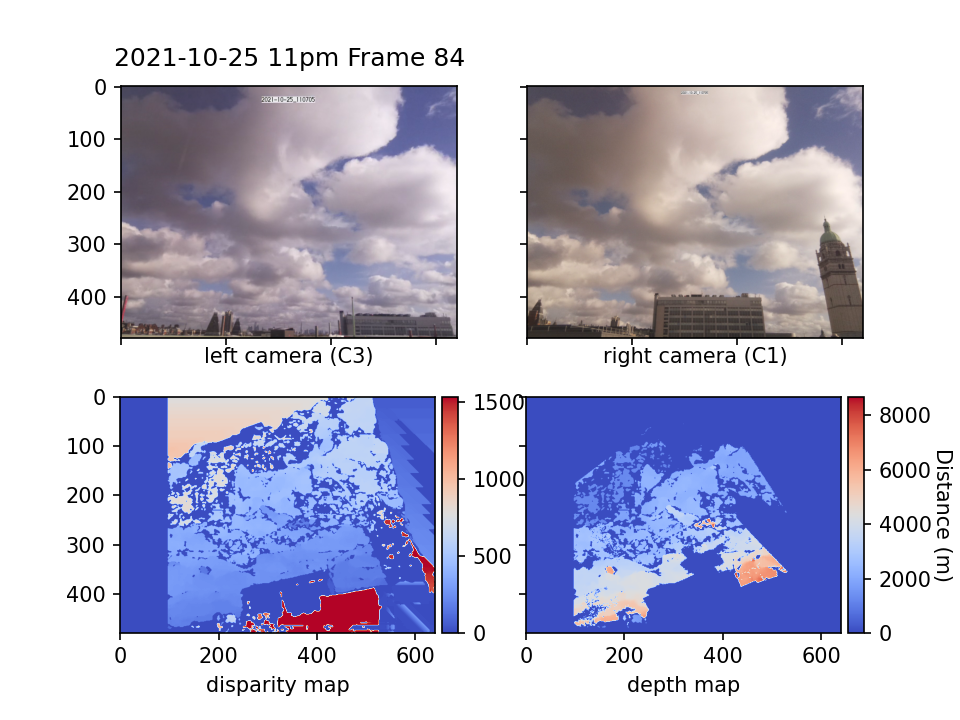

<ipython-input-118-5cd871925ab0>:133: RuntimeWarning: invalid value encountered in true_divide
  rg_ratio1 = rimgR[:, :, 1]/rimgR[:, :, 2]


frame number 84


In [118]:
%cd "C:\Users\kathe\OneDrive - Imperial College London\MSci Project\"
#camera matrices and distortion for the 640x480 resolution
#i am using the 640x480v2 values for both cameras because camera3 doesn't have its own
CamM_left = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

CamM_right = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])


Distort_left = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])
Distort_right = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])

w, h = 640, 480

#Create stereo matching object and set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error.
#win_size = 5
#min_disp = 0
#max_disp = 64
#num_disp = max_disp - min_disp # Needs to be divisible by 16
#Create Block matching object.
#stereo = cv.StereoSGBM_create(minDisparity= min_disp,
# numDisparities = num_disp,
# blockSize = 5,
# uniquenessRatio = 15,
# speckleWindowSize = 100,
# speckleRange = 2,
# disp12MaxDiff = 15,
# P1 = 8*3*win_size**2,#8*3*win_size**2,
# P2 =32*3*win_size**2) #32*3*win_size**2

#Create stereo matching object and set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error.
win_size = 8
min_disp = 1
max_disp = 7
num_disp = 16*max_disp - 16*min_disp # Needs to be divisible by 16
#Create Block matching object.
stereo = cv.StereoSGBM_create(minDisparity= min_disp,
 numDisparities = num_disp,
 blockSize = 9,
 uniquenessRatio = 13,
 speckleWindowSize = 5,
 speckleRange = 14,
 disp12MaxDiff = 7,
 P1 = 8*3*win_size**2,
 P2 =32*3*win_size**2) 

#prefix_right = 'C1'
#prefix_left = 'C3'
prefix_right = 'tl'
prefix_left = 'tl4'
vidfolder = "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/Videos/"
dtime = '2021-10-25'
hour = 11
frame_no = 83
vidcapR = cv.VideoCapture(f'{vidfolder}/{prefix_right}_{dtime}_{hour:0>2}A.mp4')
vidcapL = cv.VideoCapture(f'{vidfolder}/{prefix_left}_{dtime}_{hour:0>2}A.mp4')

# Check if camera opened successfully
if vidcapR.isOpened()== False:
    print("Error opening right camera")
if vidcapL.isOpened()== False:
    print("Error opening left camera")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True)

vidcapR.set(cv.CAP_PROP_POS_FRAMES,frame_no) # Where frame_no is the frame you want
vidcapL.set(cv.CAP_PROP_POS_FRAMES,frame_no)
successR, imgRLarge = vidcapR.read() # Read the frame
#success, imgR = vidcapR.read()
successL, imgL = vidcapL.read()
if successR==True and successL == True:
    imgL = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
    imgR = cv.resize(imgRLarge,(640,480),fx=0,fy=0, interpolation = cv.INTER_CUBIC)
    imgR = cv.cvtColor(imgR, cv.COLOR_BGR2RGB)
    vidcapR.release()
    vidcapL.release()

ax1.imshow(imgL)
ax1.set_xlabel('left camera (C3)')
ax1.set_title(f'{dtime} {hour}pm Frame {frame_no+1}', pad=10)
ax2.imshow(imgR)
ax2.set_xlabel('right camera (C1)')
imgR = cv.bitwise_and(imgR, imgR, mask=mask_C1)
imgL = cv.bitwise_and(imgL, imgL, mask=mask_C3)

#assume both images have same height and width

new_camera_matrixleft, roi = cv.getOptimalNewCameraMatrix(CamM_left,Distort_left,(w,h),1,(w,h))
new_camera_matrixright, roi = cv.getOptimalNewCameraMatrix(CamM_right,Distort_right,(w,h),1,(w,h))

#Undistort images
imgR_undistorted = cv.undistort(imgR, CamM_right, Distort_right, None, new_camera_matrixright)
imgL_undistorted = cv.undistort(imgL, CamM_left, Distort_left, None, new_camera_matrixleft)

#creates new map for each camera with the rotation and pose (R and P) values
mapLx, mapLy = cv.initUndistortRectifyMap(new_camera_matrixleft, Distort_left, Rleft, Pleft, (w,h), cv.CV_32FC1)
mapRx, mapRy = cv.initUndistortRectifyMap(new_camera_matrixright, Distort_right, Rright, Pright, (w,h), cv.CV_32FC1)

# remaps each image to the new map
rimgR = cv.remap(imgR, mapRx, mapRy,
                      interpolation=cv.INTER_NEAREST,
                      borderMode=cv.BORDER_CONSTANT,
                      borderValue=(0, 0, 0, 0))
rimgL = cv.remap(imgL, mapLx, mapLy,
                      interpolation=cv.INTER_NEAREST,
                      borderMode=cv.BORDER_CONSTANT,
                      borderValue=(0, 0, 0, 0))

# compute disparity map for the rectified images
disparity_map = stereo.compute(rimgL, rimgR).astype(np.float32)

im3d = cv.reprojectImageTo3D(disparity_map/32, Q, handleMissingValues = True)
im3d[im3d == np.inf] = 0
im3d[im3d > 8_000] = 0
im3d[im3d < -8_000] = 0
im3d[im3d == -np.inf] = 0
im3d[im3d[:,:,2] == 0] = 0
im3d[im3d[:,:,1] == 0] = 0
im3d[im3d[:,:,0] == 0] = 0


depths = np.sqrt(im3d[:,:,0]**2 + im3d[:,:,1]**2 + im3d[:,:,2]**2)
stereo_x = im3d[:,:,0]
stereo_y = im3d[:,:,1]
stereo_z = im3d[:,:,2]

### uncomment if you want to mask out sky ###
rg_ratio1 = rimgR[:, :, 1]/rimgR[:, :, 2]
skymask_C1 =  mask_C1[:,:,0] & (rg_ratio1<1.1) & (rg_ratio1>0.93)
#depths_skymask = cv.bitwise_and(depths, depths, mask=skymask_C1)

#combine mask1 and mask3 and rectify 
new_mask = mask_C1[:,:,0] & mask_C3[:,:,0]
disp_mask = cv.remap(skymask_C1, mapLx, mapLy,
                            interpolation=cv.INTER_NEAREST,
                            borderMode=cv.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))

depths = cv.bitwise_and(depths, depths, mask=disp_mask)

disp = ax3.imshow(disparity_map,'coolwarm')
ax3.set_xlabel('disparity map')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(disp, cax=cax, orientation='vertical')
#cbar.set_label('Disparity', rotation=270, labelpad=6)

depth = ax4.imshow(depths, 'coolwarm')
ax4.set_xlabel('depth map')
divider2 = make_axes_locatable(ax4)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(depth, cax=cax2, orientation='vertical')
cbar2.set_label('Distance (m)', rotation=270, labelpad=10)
plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_disp_buildingMaskNoZeros.png', bbox_inches='tight')
print('frame number', frame_no+1)
    
    







In [113]:
import cameratransform as ct
# Our origin is at camera 3 so we want all the parameters for this camera

# intrinsic camera parameters
f_mm = 3.04    # in mm
pixel_size = 1.12e-3 # length of one side of square pixel in mm
sensor_size = (3.68, 2.76) # in mm
image_size = (w,h)    # in px
f_x_px = (f_mm /sensor_size[0]) * image_size[0] #focal length relative to pixel width
f_y_px = (f_mm /sensor_size[1]) * image_size[1] #focallength relative to pixel height

camera = ct.Camera(ct.RectilinearProjection(focallength_x_px = f_x_px, focallength_y_px = f_y_px, image = rimgL))
camera.setGPSpos(51.4993318750954, -0.17901837289811393, 46)
#using values calculated for camera 3 using cameratransform
camera.elevation_m = 46
camera.tilt_deg = 110.847355
camera.heading_deg = 90.425038
camera.roll_deg = -19.934881        #110.847355    90.425038 -19.934881

In [114]:
depth_x = []
depth_y = []
depth_val = []
space_coords = []
world_coords = []
heights = []
for j in range (0,480):
    for i in range (0,640):
        if 0 < depths[j,i] < 7000:
            if stereo_z[j,i] != 0:
                depth_val.append(depths[j,i])
                depth_x.append(i)
                depth_y.append(j)
                elev = np.arccos(stereo_z[j,i]/depths[j,i])
                tilt = (np.pi/180) * (camera.tilt_deg - 90)
                world_coord = camera.gpsFromSpace(np.array([stereo_z[j,i], -stereo_x[j,i], stereo_y[j,i]]))
                heights.append(stereo_z[j,i] * np.tan(elev+tilt) + 46)
                world_coords.append(world_coord)    
                space_coord = camera.spaceFromImage([i,j], Z=depths[j,i])
                space_coords.append(np.array(space_coord))
        
depth_x = np.array(depth_x)
depth_y = np.array(depth_y)  
depth_val = np.array(depth_val)
space_coords = np.array(space_coords)
world_coords = np.array(world_coords)
heights = np.array(heights)

<IPython.core.display.Javascript object>


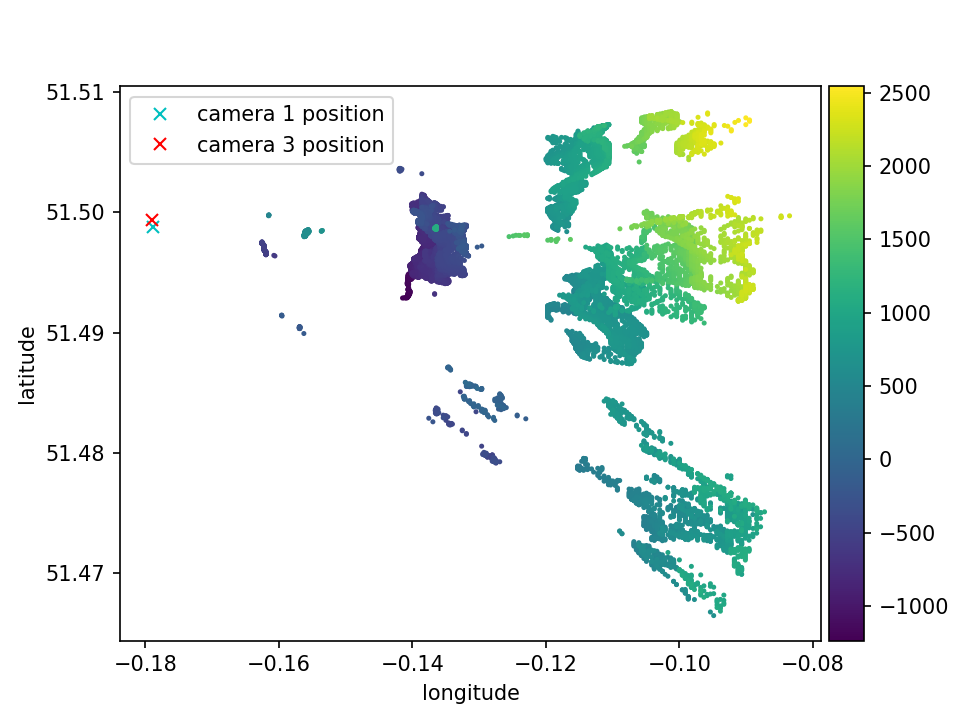

In [117]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
world = ax.scatter(world_coords[:,1], world_coords[:,0], 2, world_coords[:,2])
ax.plot(-0.1788492157810761, 51.49880908055068, 'cx', label='camera 1 position')
ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3 position')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=20)
ax.legend()
plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_worldNegativeHeights.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


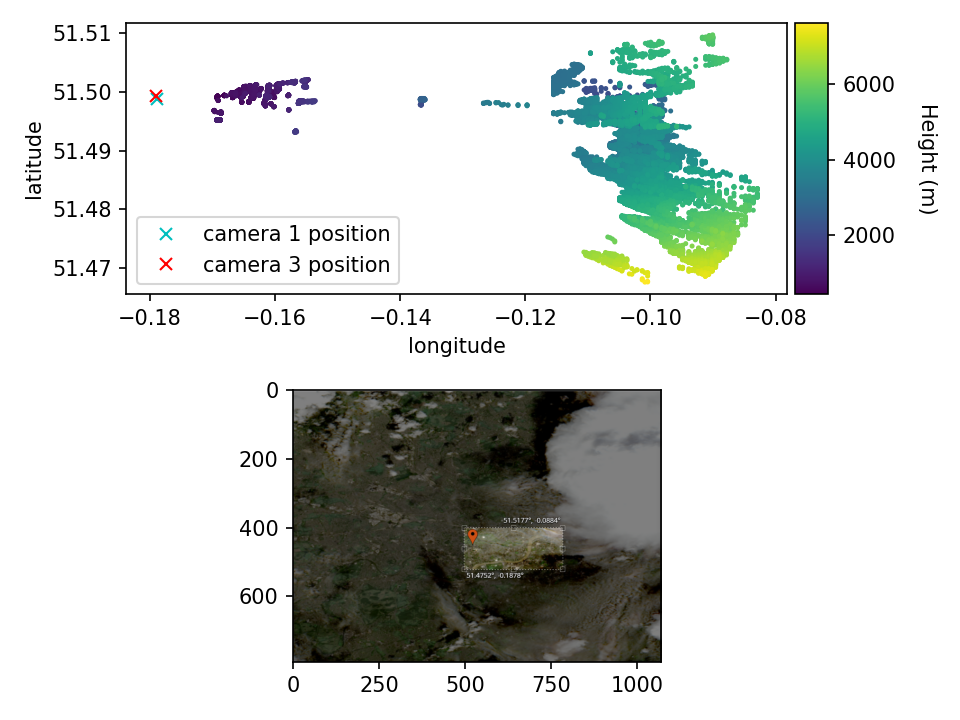

In [108]:
#sat = plt.imread('snapshot-2021-10-25T00_00_00Z.jpg')
sat = plt.imread('2022-01-26-satellite.png')
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xlabel('longitude')
ax1.set_ylabel('latitude')
world = ax1.scatter(world_coords[:,1], world_coords[:,0], 2, heights)
ax1.plot(-0.1788492157810761, 51.49880908055068, 'cx', label='camera 1 position')
ax1.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3 position')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=20)
ax1.legend()
ax2.imshow(sat)
plt.tight_layout()
#plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_worldSatelliteComparison.png', bbox_inches='tight')